In [1]:
from pandas import read_csv, get_dummies, DataFrame
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = read_csv('data/clean.csv')
df.drop(['id', 'memUsage', 'freeMem', 'totalMem', 'timestamp'], axis=1, inplace=True)
df = df.groupby(['instanceType', 'serverType', 'databaseType', 'requestSize', 'frequency']).mean().reset_index()
df['instanceType'] = df['instanceType'].astype('category')
df['serverType'] = df['serverType'].astype('category')
df['databaseType'] = df['databaseType'].astype('category')

encoded = get_dummies(df, columns=['instanceType', 'serverType', 'databaseType']).sample(frac=1).reset_index(drop=True)
display(df.shape, encoded.shape)

(1058, 10)

(1058, 15)

In [3]:
label_cols = ['timeWrite', 'timeRead', 'timeDelete', 'totalTime', 'clientTotalTime']

features = encoded.drop(label_cols, axis=1)
features_scaled = StandardScaler().fit_transform(features.to_numpy())
target = encoded[label_cols]
columns = features.columns

display(features)
display(target)

,requestSize,frequency,instanceType_b1,instanceType_b2,instanceType_b4,instanceType_b8,serverType_java,serverType_nodejs,databaseType_nosql,databaseType_sql
0,200.0,60.0,1,0,0,0,0,1,1,0
1,200.0,20.0,0,0,1,0,0,1,1,0
2,50.0,10.0,0,1,0,0,1,0,0,1
3,50.0,4.0,0,1,0,0,0,1,0,1
4,20.0,5.0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1053,20.0,40.0,0,0,1,0,0,1,0,1
1054,50.0,60.0,0,1,0,0,0,1,1,0
1055,20.0,10.0,0,0,0,1,0,1,0,1
1056,1.0,5.0,1,0,0,0,1,0,1,0


,timeWrite,timeRead,timeDelete,totalTime,clientTotalTime
0,154.849057,107.075472,102.188679,629.075472,8460.754717
1,146.456562,102.430684,84.128466,531.000924,9991.272643
2,13.163387,4.994801,6.209061,81.618270,273.896027
3,20.447124,6.451763,6.987941,217.671614,496.015770
4,11.828047,3.222037,5.393990,83.001669,253.631052
...,...,...,...,...,...
1053,23.125541,17.848485,21.203463,218.363636,7317.281385
1054,121.967033,77.000000,121.038462,635.873626,8462.241758
1055,9.286160,3.460441,5.866726,129.668375,295.576777
1056,95.042649,52.028058,74.251403,310.255892,8003.740741


In [4]:
models = []
seeds = range(0, 10000 + 1, 10)

def score(y_true, y_pred):
    return r2_score(y_true, y_pred, multioutput='uniform_average')

def get_top_weights(weights):
    top_2 = list(map(lambda x: x.argsort()[-2:][::-1], weights))
    names = list(map(lambda x: list(map(lambda y: columns[y].split('_')[0], x)), top_2))
    return names

for seed in seeds:
    clear_output()
    display(seed)
        
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target.to_numpy(), random_state=seed)   
    
    lreg = LinearRegression().fit(X_train, y_train)
    models.append({
        'name': 'LinearRegression',
        'train_score': score(y_train, lreg.predict(X_train)),
        'test_score': score(y_test, lreg.predict(X_test)),
        'weights': get_top_weights(lreg.coef_),
        'seed': seed
    })
    
    ri = Ridge(random_state=seed).fit(X_train, y_train)
    models.append({
        'name': 'Ridge',
        'train_score': score(y_train, ri.predict(X_train)),
        'test_score': score(y_test, ri.predict(X_test)),
        'weights': get_top_weights(ri.coef_),
        'seed': seed
    })
    
    la = Lasso(random_state=seed).fit(X_train, y_train)
    models.append({
        'name': 'Lasso',
        'train_score': score(y_train, la.predict(X_train)),
        'test_score': score(y_test, la.predict(X_test)),
        'weights': get_top_weights(la.coef_),
        'seed': seed
    })
    
    el = ElasticNet(random_state=seed).fit(X_train, y_train)
    models.append({
        'name': 'ElasticNet',
        'train_score': score(y_train, el.predict(X_train)),
        'test_score': score(y_test, el.predict(X_test)),
        'weights': get_top_weights(el.coef_),
        'seed': seed
    })
    
    rf = RandomForestRegressor(n_estimators=1000, random_state=seed).fit(X_train, y_train)
    models.append({
        'name': 'RandomForest',
        'train_score': score(y_train, rf.predict(X_train)),
        'test_score': score(y_test, rf.predict(X_test)),
        'seed': seed
    })

10000

In [5]:
model_df = DataFrame(data=models)
model_df.head()

,name,train_score,test_score,weights,seed
0,LinearRegression,0.674375,0.661860,"[[serverType, serverType], [serverType, server...",0
1,Ridge,0.674558,0.663024,"[[requestSize, databaseType], [requestSize, da...",0
2,Lasso,0.672213,0.661993,"[[requestSize, databaseType], [requestSize, da...",0
3,ElasticNet,0.621465,0.620452,"[[requestSize, databaseType], [requestSize, da...",0
4,RandomForest,0.968823,0.785568,NaN,0


In [6]:
best = model_df.loc[model_df.groupby('name')['test_score'].idxmax()]
best.drop(['weights'], axis=1, inplace=True)
best.sort_values(by=['test_score'], ascending=False, inplace=True)
best

,name,train_score,test_score,seed
1514,RandomForest,0.966856,0.870360,3020
82,Lasso,0.653237,0.742266,160
81,Ridge,0.655471,0.737204,160
80,LinearRegression,0.655431,0.735643,160
588,ElasticNet,0.606544,0.715014,1170


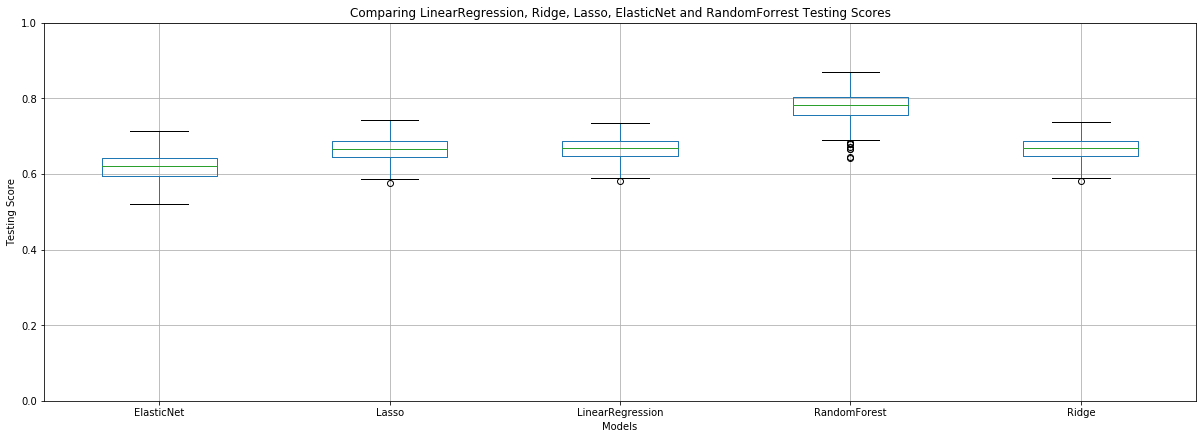

In [7]:
ax = model_df[['name', 'test_score']].boxplot(by='name', figsize=(20, 7))
ax.set_ylim(0, 1)
ax.set_xlabel('Models')
ax.set_title('Comparing LinearRegression, Ridge, Lasso, ElasticNet and RandomForrest Testing Scores')
ax.set_ylabel('Testing Score')
fig = ax.get_figure()
fig.suptitle('')
plt.savefig('graphs/models/testing-scores.png', bbox_inches='tight')
plt.show()

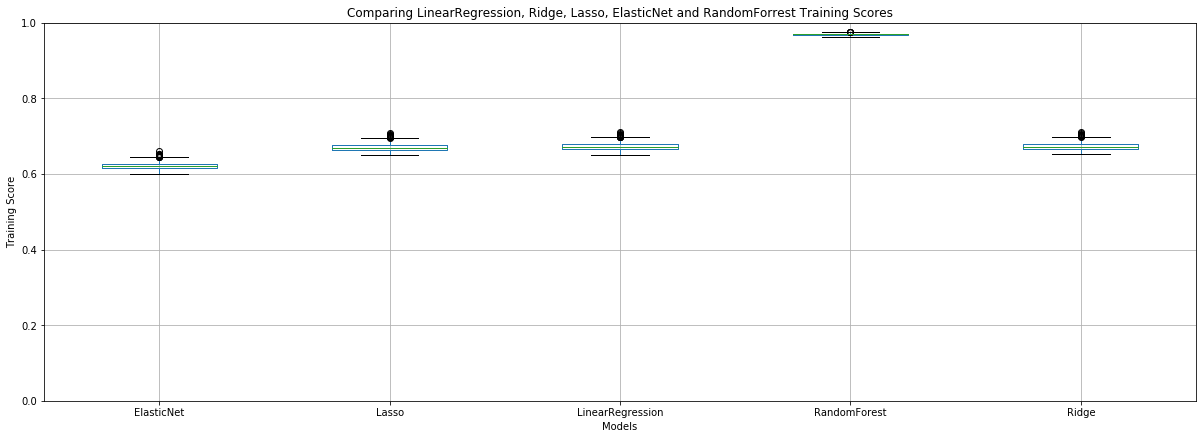

In [8]:
ax = model_df[['name', 'train_score']].boxplot(by='name', figsize=(20, 7))
ax.set_ylim(0, 1)
ax.set_xlabel('Models')
ax.set_title('Comparing LinearRegression, Ridge, Lasso, ElasticNet and RandomForrest Training Scores')
ax.set_ylabel('Training Score')
fig = ax.get_figure()
fig.suptitle('')
plt.savefig('graphs/models/training-scores.png', bbox_inches='tight')
plt.show()

In [14]:
model_df.loc[82]['weights']

[['requestSize', 'databaseType'],
 ['databaseType', 'requestSize'],
 ['databaseType', 'requestSize'],
 ['databaseType', 'requestSize'],
 ['frequency', 'instanceType']]